# Exercise 1

Data analysis

Steps:
- Load data
- Compléter S1 à partir de S2 en trouvant une corrélation entre les deux (plot l'un en fonction de l'autre) !!! Utiliser les maTime annuels!!!
- A partir de polynomes (autocorrelation), allonger les datas sur 30 ans, utiliser une shuffle (Swap) technique
- Flow minimal: atteint 95% du temps à calculer
- A partir des deux plots sur 30 ans, calculer la moyenne puis determiner la tendance sur chaque mois pendant un an
- Determiner la période humide/seche en les divisant en utilisant la moyenne.


## Data Loading

In [241]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt



In [242]:
S1flow=pd.read_table("./data/Stations/S1flow.txt",header=None, engine="python", names=['S1'])
#S1flow.columns=["S1"] 
print(S1flow.head())


           S1
0  106.870920
1  139.441930
2   61.254229
3   56.156909
4   80.952344


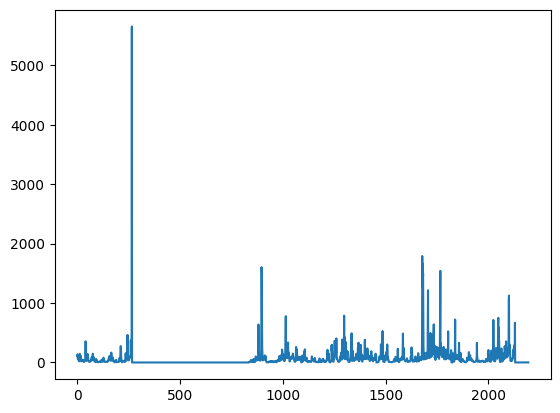

In [243]:
plt.plot(S1flow)

In [244]:
S2flow=pd.read_csv("./data/Stations/S2flow.txt", sep='  ', header=None,engine="python")
S2flow=S2flow.transpose()
S2flow.columns=["S2"]
S2flow.head(20)

,S2
0,1.727905
1,5.281199
2,8.754718
3,21.166835
4,34.468974
5,68.130408
6,185.068000
7,47.333427
8,41.016026
9,21.742803


7305

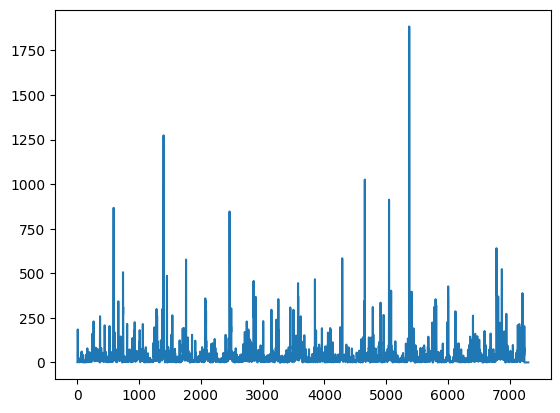

In [245]:

plt.plot(S2flow)
len(S2flow)

In [246]:
Time = np.linspace(0,20,len(S2flow))
print(len(Time))
# Completer S1 avec des zéros
N=len(S2flow)-len(S1flow)
S1zeros=pd.DataFrame({'value': [0] * N})
# Concatenate the zeros DataFrame with the original DataFrame
completed_S1flow = pd.concat([S1zeros, S1flow], ignore_index=True)
completed_S1flow=completed_S1flow['S1']
completed_S1flow



7305


0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
7300    1.345
7301    1.277
7302    1.568
7303    2.653
7304    1.386
Name: S1, Length: 7305, dtype: float64

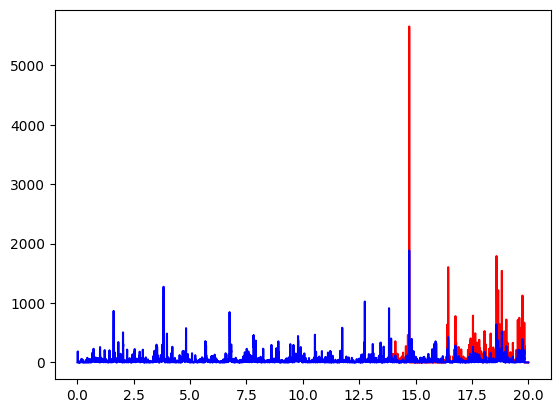

In [247]:
plt.plot(Time,completed_S1flow, color='r', label='S1')
plt.plot(Time,S2flow, color='blue')

In [248]:
# Define the beginning and ending dates
start_date = '2003-01-01'
end_date = '2022-12-31'

# Generate a date range
date_range = pd.date_range(start=start_date, end=end_date, periods=len(S2flow))
# Create global dataset
Discharge=S2flow
# Assign the date range to a new column in the DataFrame
Discharge['Date'] = pd.to_datetime(date_range)
Discharge['S1']=completed_S1flow
print(Discharge)

             S2       Date     S1
0      1.727905 2003-01-01    NaN
1      5.281199 2003-01-02    NaN
2      8.754718 2003-01-03    NaN
3     21.166835 2003-01-04    NaN
4     34.468974 2003-01-05    NaN
...         ...        ...    ...
7300   0.382368 2022-12-27  1.345
7301   0.425667 2022-12-28  1.277
7302   0.583371 2022-12-29  1.568
7303   0.739186 2022-12-30  2.653
7304   0.594796 2022-12-31  1.386

[7305 rows x 3 columns]


             S2       Date         S1
6939  26.865176 2021-12-31  70.584915
6940  20.233395 2022-01-01  52.355518
6941  20.619665 2022-01-02  61.858995
6942  10.281034 2022-01-03  30.843102
6943   3.424341 2022-01-04  13.564053
...         ...        ...        ...
7300   0.382368 2022-12-27   1.345000
7301   0.425667 2022-12-28   1.277000
7302   0.583371 2022-12-29   1.568000
7303   0.739186 2022-12-30   2.653000
7304   0.594796 2022-12-31   1.386000

[366 rows x 3 columns]


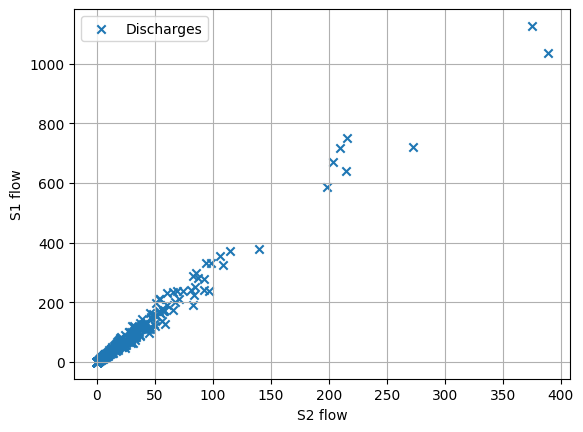

In [249]:
Last_year_data=Discharge[Discharge['Date']>=pd.to_datetime(end_date)- pd.DateOffset(years=1)]
print(Last_year_data)
from pathlib import Path  
filepath = Path('last_year_flow.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
Last_year_data.to_csv(filepath)
plt.scatter(Last_year_data['S2'],Last_year_data['S1'],marker='x', label='Discharges')
plt.xlabel('S2 flow')
plt.ylabel('S1 flow')
plt.legend()
plt.grid()

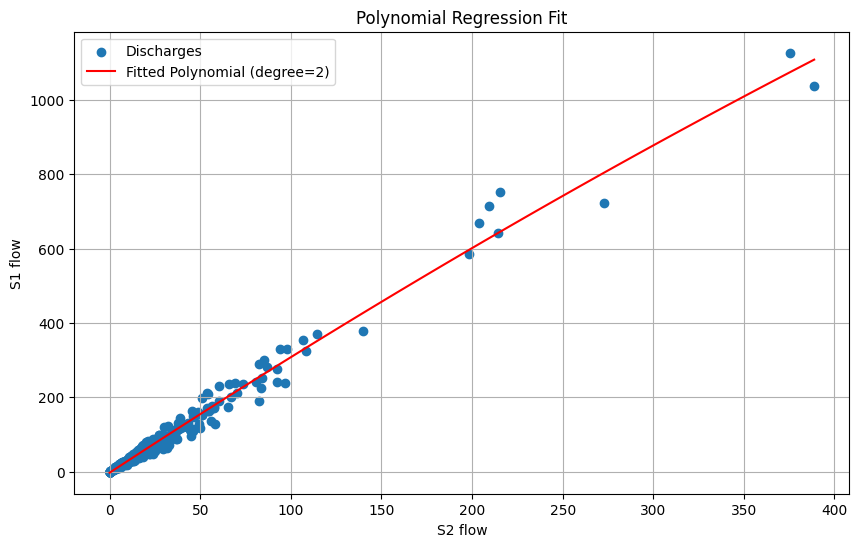

In [250]:

# Fit a polynomial regression model
degree = 2
coefficients = np.polyfit(Last_year_data['S2'],Last_year_data['S1'], degree)
polynomial = np.poly1d(coefficients)

# Generate x values for the fitted curve
x_fit = np.linspace(Last_year_data['S2'].min(), Last_year_data['S2'].max(), 100)
y_fit = polynomial(x_fit)

# Plot the original data points and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(Last_year_data['S2'],Last_year_data['S1'], label='Discharges')
plt.plot(x_fit, y_fit, color='red', label=f'Fitted Polynomial (degree={degree})')
plt.xlabel('S2 flow')
plt.ylabel('S1 flow')
plt.grid()
plt.title('Polynomial Regression Fit')
plt.legend()
plt.show()


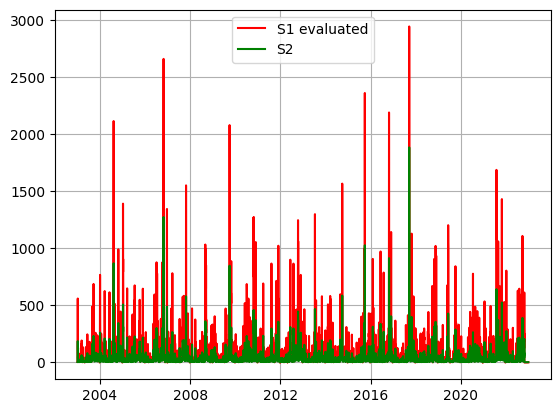

In [251]:
# Complete with values S1 from plynomial(S2,S1)
Discharge['S1']=polynomial(Discharge['S2'])
plt.plot(Discharge['Date'],Discharge['S1'], color='r', label='S1 evaluated')
plt.plot(Discharge['Date'],Discharge['S2'], color='g', label='S2')
plt.grid()
plt.legend()

In [252]:
from pathlib import Path  
filepath = Path('20_years_flow.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
Discharge.to_csv(filepath)

## b
Swapping technique, build maxima timeseries

In [253]:
Dis_max=pd.DataFrame()
Discharge.index=Discharge['Date']
Dis_max['S1']=Discharge.groupby(by=[Discharge.index.year, Discharge.index.month])['S1'].max()

In [254]:
Dis_max['S2']=Discharge.groupby(by=[Discharge.index.year, Discharge.index.month])['S2'].max()
Dis_max.index.names=['year','month']


In [255]:
Dis_max=Dis_max.reset_index()


In [256]:
# Combine 'year' and 'month' into a single 'Date' column
Dis_max['Date'] = pd.to_datetime(Dis_max[['year', 'month']].assign(DAY=1))

# Drop the original 'year' and 'month' columns
Dis_max = Dis_max.drop(columns=['year', 'month'])

# Optionally, set 'Date' as the index
Dis_max.set_index('Date', inplace=True)
Dis_max

,S1,S2
Date,,
2003-01-01,558.396705,185.068000
2003-02-01,126.429194,40.840694
2003-03-01,190.276448,61.425097
2003-04-01,130.652587,42.195074
2003-05-01,133.604181,43.142210
...,...,...
2022-08-01,644.438807,215.316550
2022-09-01,1107.414607,388.799040
2022-10-01,611.370631,203.625450


(0.0, 60.0)

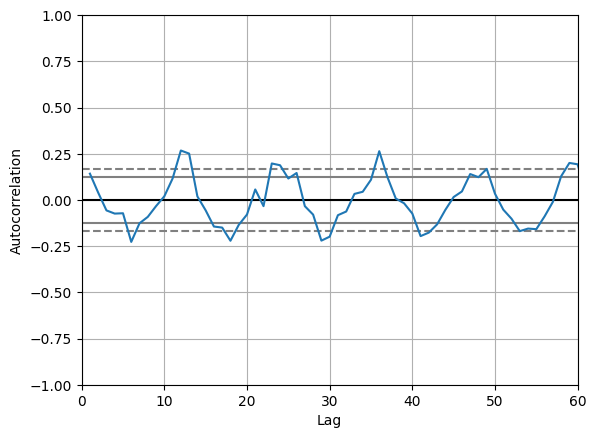

In [257]:
pd.plotting.autocorrelation_plot(Dis_max['S1'])
plt.xlim((0,5*12))

On observe une corrélation forte et négative pour 6 mois de lag, et une forte et positive au bout de 1 an. Le schéma se répète au fur et à mesure des années.

In [ ]:
# On veut construire 10 ans
#Pour cela, on commence à créer de l'aléatoire
from numpy import random as rd 

temp=pd.DataFrame()
for y in range(0,10):
    for m in range(1, 13):
        # Input random numbers
        step_y=rd.randint(0,19)
        print('step_y:',step_y)

        # Define time to take from
        lap=12*(step_y+1) #months, 2 years frequency
        print("lap:", lap,'months')
        ini_date=pd.to_datetime('2023-01-01')-pd.DateOffset(months=lap)+pd.DateOffset(months=(m-1))
        print("Initial date:", ini_date)
        last_date=ini_date+pd.DateOffset(months=1)

        # take month to load
        temp=Discharge[(Discharge.index>=ini_date) & (Discharge.index<last_date)]
        # add index dates
        temp.index=temp.index+pd.DateOffset(years=(y+step_y+1))
        #print(temp.tail())
        Discharge=pd.concat((Discharge, temp),axis=0)


step_y: 15
lap: 192 months
Initial date: 2007-01-01 00:00:00
                   S2       Date         S1
Date                                       
2023-01-27  23.902684 2007-01-27  73.343689
2023-01-28  12.527310 2007-01-28  37.414173
2023-01-29   6.969216 2007-01-29  19.777532
2023-01-30   5.536717 2007-01-30  15.223364
2023-01-31   6.205626 2007-01-31  17.350384
step_y: 8
lap: 108 months
Initial date: 2014-02-01 00:00:00
                  S2       Date        S1
Date                                     
2023-02-24  2.995900 2014-02-24  7.136946
2023-02-25  1.835859 2014-02-25  3.441287
2023-02-26  1.719296 2014-02-26  3.069814
2023-02-27  2.027060 2014-02-27  4.050575
2023-02-28  2.514459 2014-02-28  5.603452
step_y: 18
lap: 228 months
Initial date: 2004-03-01 00:00:00
                  S2       Date         S1
Date                                      
2023-03-27  4.984120 2004-03-27  13.465614
2023-03-28  3.952013 2004-03-28  10.181183
2023-03-29  3.901269 2004-03-29  10.019655
2

In [259]:
Discharge

,S2,Date,S1
Date,,,
2003-01-01,1.727905,2003-01-01,3.097249
2003-01-02,5.281199,2003-01-02,14.410653
2003-01-03,8.754718,2003-01-03,25.449001
2003-01-04,21.166835,2003-01-04,64.722809
2003-01-05,34.468974,2003-01-05,106.517644
...,...,...,...
2032-12-27,0.227662,2013-12-27,-1.685947
2032-12-28,0.123667,2013-12-28,-2.017656
2032-12-29,28.712020,2013-12-29,88.466984


In [265]:
from pathlib import Path  
filepath = Path('30_years_flow.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
Discharge.to_csv(filepath)

## c 
Build the flow duration curve of the 30 years dataset for reconstructed station one data and 
calculate 
the reference minimal flow for instream flow protection based on the Q347 approach

In [266]:
Flow=pd.read_csv("30_years_flow.csv")
Flow


,Date,S2,Date.1,S1
0,2003-01-01,1.727905,2003-01-01,3.097249
1,2003-01-02,5.281199,2003-01-02,14.410653
2,2003-01-03,8.754718,2003-01-03,25.449001
3,2003-01-04,21.166835,2003-01-04,64.722809
4,2003-01-05,34.468974,2003-01-05,106.517644
...,...,...,...,...
10953,2032-12-27,0.227662,2013-12-27,-1.685947
10954,2032-12-28,0.123667,2013-12-28,-2.017656
10955,2032-12-29,28.712020,2013-12-29,88.466984
10956,2032-12-30,90.434351,2013-12-30,279.013978


0        2944.893540
1        2660.556227
2        2450.102015
3        2361.334646
4        2190.356510
            ...     
10953      -2.412136
10954      -2.412136
10955      -2.412136
10956      -2.412136
10957      -2.412136
Name: S1, Length: 10958, dtype: float64


Text(0.5, 1.0, 'Charge curve of discharge (Monotone de débit)')

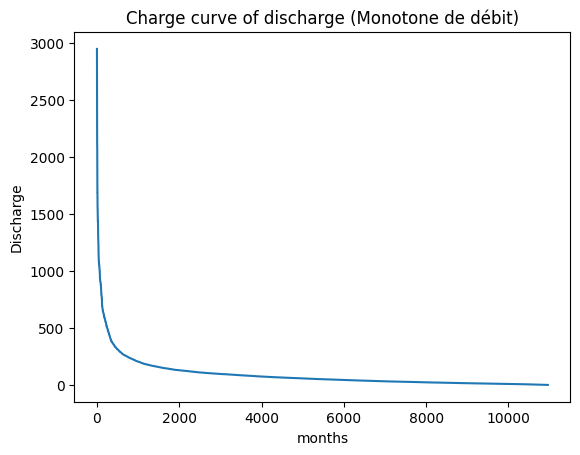

In [267]:
Flow_sorted=Flow.copy()
Flow_sorted.sort_values(by=['S1'],inplace=True, ignore_index=True,ascending=False)

print(Flow_sorted['S1'])
plt.plot(Flow_sorted['S1'])
plt.xlabel('months')
plt.ylabel('Discharge')
plt.title('Charge curve of discharge (Monotone de débit)')

In [268]:
Q347=Flow_sorted['S1'][int(95/100*len(Flow_sorted))]
Q347

3.2998703241691207

## d
Obtain the daily mean annual behaviour from data

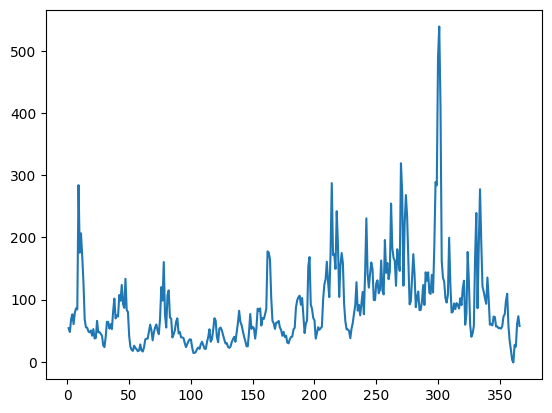

In [ ]:
# Group by day of the year and calculate the mean
daily_mean_annual_avg = Discharge.groupby(Discharge.index.dayofyear).mean()

plt.plot(daily_mean_annual_avg['S1'])

# e
Build the monthly mean annual time series, which will be used for the financial analysis

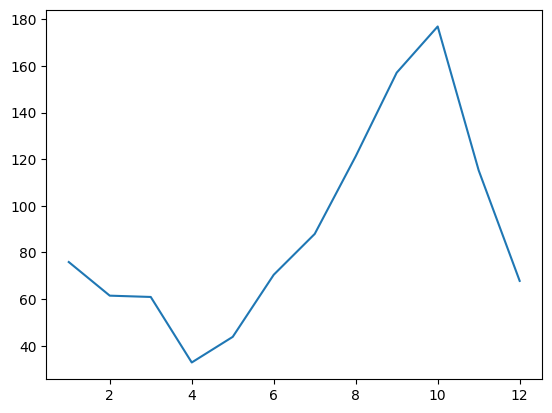

In [272]:
# Group by day of the year and calculate the mean
daily_mean_annual_avg = Discharge.groupby(Discharge.index.month).mean()

plt.plot(daily_mean_annual_avg['S1'])

# f
Use the reconstructed data for S1 to build two new series as the sequence of wet periods and the 
sequence of dry periods. To the purpose, use the annual mean as discriminant value for the wet years 
(above the mean, Aug-Dec) and viceversa. We will use these series later to build the Pareto frontier of the system

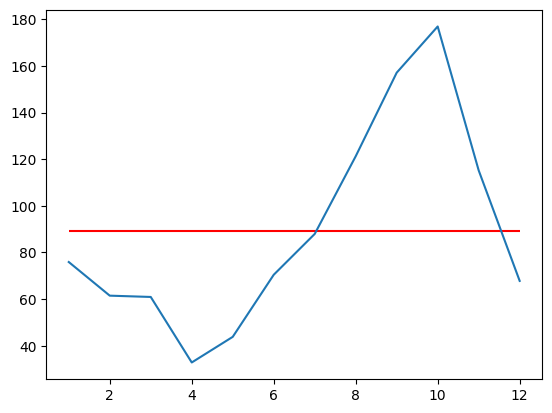

In [274]:
mean_yearly=daily_mean_annual_avg['S1'].mean()
plt.hlines(mean_yearly, xmin=1,xmax=12,colors='r',label='Mean discharge')
plt.plot(daily_mean_annual_avg['S1'])

In [281]:
Wet_periods=(Discharge['S1']>mean_yearly)
Wet_Dis=Discharge[Wet_periods]

Dry_dis=Discharge[~Wet_periods]
Dry_dis

,S2,Date,S1
Date,,,
2003-01-01,1.727905,2003-01-01,3.097249
2003-01-02,5.281199,2003-01-02,14.410653
2003-01-03,8.754718,2003-01-03,25.449001
2003-01-04,21.166835,2003-01-04,64.722809
2003-01-10,21.742803,2003-01-10,66.538803
...,...,...,...
2032-12-25,0.360349,2013-12-25,-1.262745
2032-12-26,0.368802,2013-12-26,-1.235788
2032-12-27,0.227662,2013-12-27,-1.685947
